In [2]:
from matipo.util.fft import fft_reconstruction
import numpy as np
import yaml
import matplotlib.pyplot as plt
from matplotlib import cm
import ipyvolume as ipv

### 3D Flow Velocity Vector Data Loading & Plotting

In [25]:
# set load directory and base file name
LOAD_DIR = '/home/data/flow-3D-RARE'
LOAD_NAME = 'U_bend_32'

In [26]:
G_CAL = 8.0e6 # Hz/m at max grad
DECIMATION = 4
G_FLOW_MAG = 0.5
G_FLOW_DIR = np.array([
    (1, 1, 1),
    (-1, -1, 1),
    (-1, 1, -1),
    (1, -1, -1)
])
# multiply magnitude by normalised directions
G_FLOW = G_FLOW_MAG * (G_FLOW_DIR/np.linalg.norm(G_FLOW_DIR, axis=1)[:,np.newaxis])
# calculate VENC, the velocity that produces a pi phase shift
g_flow_x = np.diagonal(np.dot(G_FLOW.T, G_FLOW_DIR))[0]

with open(f'{LOAD_DIR}/{LOAD_NAME}.yaml', 'r') as f:
    par = yaml.load(f, Loader=yaml.UnsafeLoader)
n_phase_1 = par['n_phase_1']
n_phase_2 = par['n_phase_2']
n_samples = par['n_samples']
data = np.load(f'{LOAD_DIR}/{LOAD_NAME}.npy')

VENC = np.pi/(2*np.pi*G_CAL*g_flow_x*par['t_flow']*par['t_flow_spacing']) # assume VENC same for all dimensions for now

In [27]:
im = []
for i in range(len(G_FLOW)):
    # run IFT with some upscaling and windowing to get the images
    im.append(fft_reconstruction(data[i], upscale_factor=1, gaussian_blur=1))
im = np.array(im)

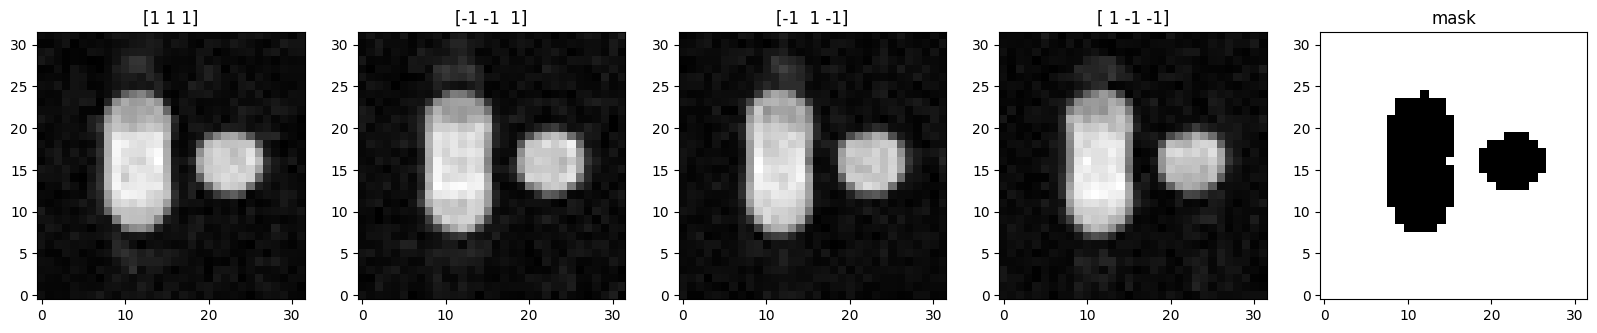

In [28]:
# make a filter array by thresholding the magnitude of the base signal
# this can be used to exclude areas with no signal when plotting phase difference
filt = np.mean(np.abs(im)**2, axis=0)
thresh = 0.2*np.max(filt) # adjust to alter the threshold, half max is a good starting point
filt[filt > thresh] = 1
filt[filt <= thresh] = np.nan

# plot X/Y slice of signal magnitude at the centre of the Z axis
# to check we have signal in all images
cmap='gray'
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i in range(4):
    axes.flatten()[i].imshow(np.abs(im[i][:,:,im[i].shape[2]//2]), origin='lower', cmap=cmap)
    axes.flatten()[i].set_title(str(G_FLOW_DIR[i]))
axes.flatten()[4].imshow(np.abs(filt[:,:,filt.shape[2]//2]), origin='lower', cmap=cmap)
axes.flatten()[4].set_title('mask')
plt.show()

In [29]:
# calculate velocity from phase difference (uncalibrated, arbitrary units)
v = np.zeros((3, im.shape[1],im.shape[2],im.shape[3]))

# calculate phase and matrix multiply to get Vx, Vy, Vz
im_phase = np.angle(im)
phi = np.dot((filt[np.newaxis]*im_phase).T, G_FLOW_DIR).T
phi = ( phi + np.pi) % (2 * np.pi ) - np.pi # wrap phase

v = (phi/np.pi)*VENC

# complex multiplication/division method to avoid phase wrap errors
# v[0] = filt[np.newaxis]*np.angle((im[0]*im[3])/(im[1]*im[2]))
# v[1] = filt[np.newaxis]*np.angle((im[0]*im[2])/(im[1]*im[3]))
# v[2] = filt[np.newaxis]*np.angle((im[0]*im[1])/(im[2]*im[3]))

# maximum velocity magnitude, used for plots
v_mag_max = np.nanmax(np.linalg.norm(v, axis=0))
v_mag_max

0.03528998556979796

##### Plot flow velocity vector in YZ, XZ, and XY planes
Flow in the plane is represented by arrows, and flow through the plane (perpendicular) is represented by colour.

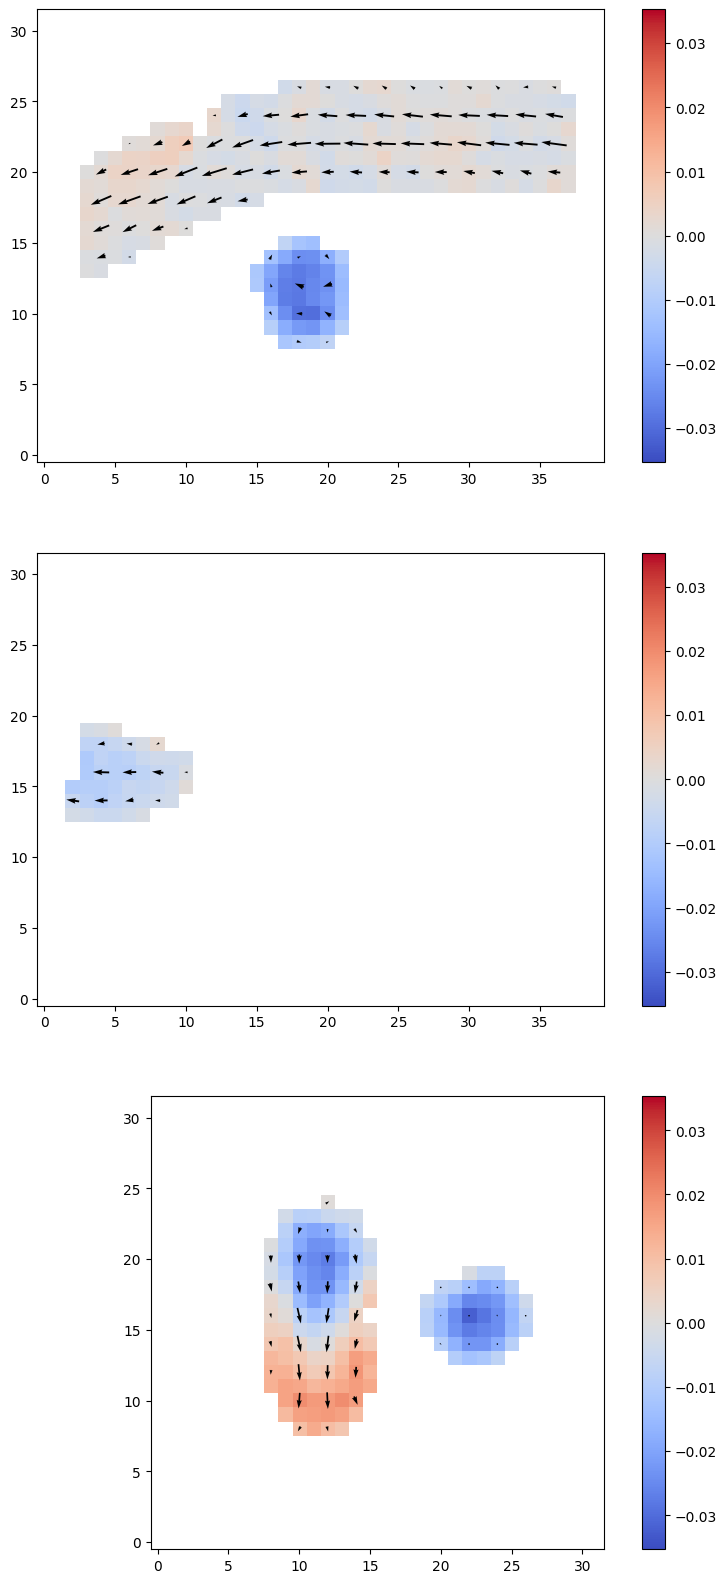

In [30]:
# For each plane through the centre (Y/Z, X/Z, X/Y) plot a map of the flow.
# The component orthogonal to the plane is represented by the backround colour
# and the component in the plane is represented by the vector arrows.
cmap='coolwarm'
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,20))
for i in range(3):
    if i==1:
        # in X/Z plane slice through U bend
        v_plane = np.take(v, v.shape[i+1]//2, axis=i+1)
    else:
        v_plane = np.take(v, v.shape[i+1]//2, axis=i+1)
    im_ = axes.flatten()[i].imshow(v_plane[i], origin='lower', cmap=cmap, vmin=-v_mag_max, vmax=v_mag_max)
    U, V = np.mgrid[0:v_plane.shape[1], 0:v_plane.shape[2]]
    vu = v_plane[1 if i==0 else 0]/v_mag_max
    vv = v_plane[1 if i==2 else 2]/v_mag_max
    axes.flatten()[i].quiver(V[::2,::2], U[::2,::2], vv[::2,::2], vu[::2,::2], pivot='mid', scale=20)
    plt.colorbar(im_, ax=axes.flatten()[i])
plt.show()

##### Plot flow velocity vectors in a 3D quiver plot with varying vector size
The arrows indicate the direction of the flow, and their size and colour indicates the speed.

In [31]:
# Plot flow velocity vectors in 3D with the vectors scaled proportional
# to flow speed (velocity magnitude).
mag_bins = [0, 0.25, 0.5, 0.75, 1.0]
sizes = [2, 4, 6, 8, 10]
colormap = cm.rainbow
ipv.figure()
mag_bins.append(100)
for mag_i in range(len(mag_bins)-1):
    X = []
    Y = []
    Z = []
    U = []
    V = []
    W = []
    C = []
    for xi in range(v.shape[1]):
        for yi in range(v.shape[2]):
            for zi in range(v.shape[3]):
                u_ = v[0, xi, yi, zi]/v_mag_max
                v_ = v[1, xi, yi, zi]/v_mag_max
                w_ = v[2, xi, yi, zi]/v_mag_max
                mag = np.sqrt(u_*u_+v_*v_+w_*w_)
                if filt[xi, yi, zi]==1 and xi%2==0 and yi%2==0 and zi%2==0 and mag > mag_bins[mag_i] and mag < mag_bins[mag_i+1]:
                    X.append(xi)
                    Y.append(yi)
                    Z.append(zi)
                    U.append(u_)
                    V.append(v_)
                    W.append(w_)
    X = np.array(X)/v.shape[1]
    Y = np.array(Y)/v.shape[2]
    Z = np.array(Z)/v.shape[3]
    U = np.array(U)
    V = np.array(V)
    W = np.array(W)
    C = colormap(np.sqrt(U*U+V*V+W*W))
    if len(X) > 0:
        ipv.quiver(X, Y, Z, U, V, W, color=C, size=sizes[mag_i])

ipv.show()

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [33]:
ipv.style.box_off()
ipv.style.axes_off()
ipv.view(90, 0, distance=1.8)

(90, 0, 1.8)

In [34]:
from time import sleep
while True:
    for angle in range(0, 360, 1):
        ipv.view(90, angle, distance=1.8)
        sleep(0.05)

KeyboardInterrupt: 